Importing dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2

I am using tf.keras.preprocessing.dataset_from_image_directory to load the data. Spliting the data: 80% training 20% validation

In [2]:
img_height = 150
img_width = 150
batch_size = 32

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/clothing-dataset-small-master/train", 
                                                                   labels='inferred', 
                                                                   seed=123, 
                                                                   batch_size=batch_size, 
                                                                   image_size=(img_height, img_width),
                                                                   
                              
                                                                   subset="training",
                                                                   validation_split=0.2)

Found 3409 files belonging to 10 classes.
Using 2728 files for training.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/clothing-dataset-small-master/train", 
                                                                   labels='inferred', 
                                                                   seed=123, 
                                                                   batch_size=batch_size, 
                                                                   image_size=(img_height, img_width),
                                                                  
                                                                   subset="validation",
                                                                   validation_split=0.2)

Found 3409 files belonging to 10 classes.
Using 681 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['dress', 'hat', 'longsleeve', 'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']


Here is a list of classes in the dataset

# Visualize the dataset

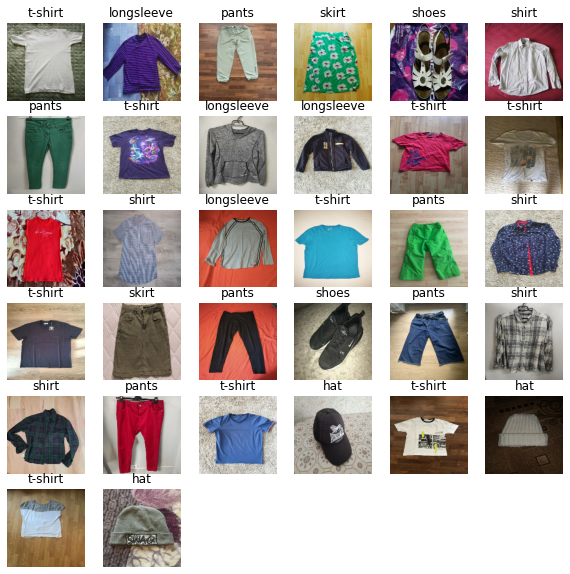

In [7]:
### To visualize the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Plotting the images
plt.show()

In [8]:
img = cv2.imread('/content/drive/MyDrive/clothing-dataset-small-master/test/dress/06a00c0f-5f9a-410d-a7da-3881a9df3a71.jpg')

In [9]:
print(img)

[[[172 188 194]
  [172 188 194]
  [172 188 194]
  ...
  [175 196 198]
  [175 196 198]
  [175 196 198]]

 [[172 188 194]
  [172 188 194]
  [172 188 194]
  ...
  [175 196 198]
  [175 196 198]
  [175 196 198]]

 [[173 189 195]
  [173 189 195]
  [173 189 195]
  ...
  [177 196 199]
  [177 196 199]
  [177 196 199]]

 ...

 [[101 110 114]
  [101 110 114]
  [101 110 114]
  ...
  [ 99 107 114]
  [100 108 115]
  [100 108 115]]

 [[101 110 114]
  [101 110 114]
  [101 110 114]
  ...
  [ 99 107 114]
  [ 99 107 114]
  [ 99 107 114]]

 [[100 109 113]
  [100 109 113]
  [100 109 113]
  ...
  [100 108 115]
  [ 99 107 114]
  [ 97 105 112]]]


In [10]:
img.shape

(711, 400, 3)

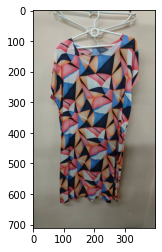

In [11]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [12]:
images[0]

<tf.Tensor: shape=(150, 150, 3), dtype=float32, numpy=
array([[[133.91055 , 135.91055 , 122.91055 ],
        [ 80.38333 ,  82.38333 ,  68.88333 ],
        [ 78.88833 ,  81.88833 ,  64.88833 ],
        ...,
        [109.86835 , 116.86835 , 100.86835 ],
        [ 97.28667 , 104.28667 ,  88.28667 ],
        [103.33406 , 110.33406 ,  94.33406 ]],

       [[104.441666, 106.441666,  93.441666],
        [ 75.745   ,  77.745   ,  64.245   ],
        [ 86.025   ,  89.025   ,  72.025   ],
        ...,
        [ 94.36833 , 101.36833 ,  85.36833 ],
        [ 91.405   ,  98.405   ,  82.405   ],
        [103.626785, 110.626785,  94.626785]],

       [[ 85.15278 ,  87.15278 ,  74.15278 ],
        [ 83.85834 ,  85.85834 ,  72.35834 ],
        [ 99.85556 , 102.85556 ,  85.85556 ],
        ...,
        [ 94.016655, 101.016655,  85.016655],
        [ 87.85    ,  94.85    ,  78.85    ],
        [ 94.28342 , 101.28342 ,  85.28342 ]],

       ...,

       [[ 46.8472  ,  49.8472  ,  32.8472  ],
        [ 52.

In [13]:
labels[0]

<tf.Tensor: shape=(), dtype=int32, numpy=9>

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


This is a batch of 32 images, shape of 150x150 and 3 is the RGB color channel. label_batch specifies the labels of 32 images. 

# Configuring the dataset for performance



In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardization

Making the dataset values between the range f [0, 1]

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99582374


# Creating a model

Creating a basic keras Sequential model with 3 convulation layers. maxPooling layer and the activation function relu.


In [23]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10)
])

## Compiling the model

Optimizer choosen is adam and the loss function is tf.keras.losses.SparseCategoricalCrossentropy. Passing the metrics argument to view the training and test data accuracy.

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 64)       

## Training the model

In [26]:
history = model.fit(
  train_ds,
  epochs=10,
  validation_data=test_ds
)

Epoch 1/10
86/86 [==============================] - 59s 679ms/step - loss: 1.8887 - accuracy: 0.3779 - val_loss: 1.6118 - val_accuracy: 0.4860
Epoch 2/10
86/86 [==============================] - 59s 681ms/step - loss: 1.3253 - accuracy: 0.5557 - val_loss: 1.2857 - val_accuracy: 0.5786
Epoch 3/10
86/86 [==============================] - 58s 680ms/step - loss: 0.9691 - accuracy: 0.6902 - val_loss: 1.1346 - val_accuracy: 0.6270
Epoch 4/10
86/86 [==============================] - 59s 690ms/step - loss: 0.6452 - accuracy: 0.7900 - val_loss: 1.0525 - val_accuracy: 0.6637
Epoch 5/10
86/86 [==============================] - 60s 698ms/step - loss: 0.4518 - accuracy: 0.8541 - val_loss: 1.1425 - val_accuracy: 0.6946
Epoch 6/10
86/86 [==============================] - 59s 687ms/step - loss: 0.2785 - accuracy: 0.9146 - val_loss: 1.2504 - val_accuracy: 0.6652
Epoch 7/10
86/86 [==============================] - 60s 695ms/step - loss: 0.1649 - accuracy: 0.9516 - val_loss: 1.3464 - val_accuracy: 0.6740

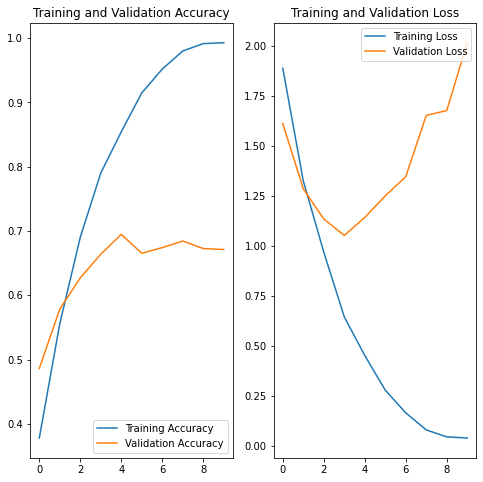

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

My model here has achieved 67% accuracy on the test data and 99% accuracy on the test data set. There is a very large difference between the train and test dataset. This clearly means that my model is overfitting. 

To deal with overfitting I am using data agumentation and add droupout to the model.


In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

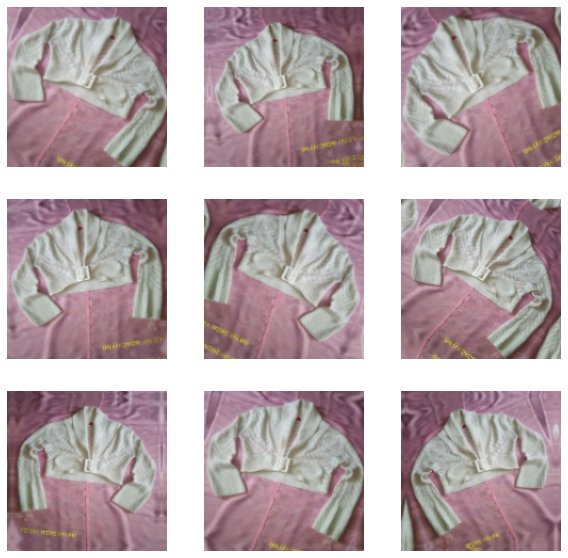

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

Compile and training the model

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [36]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
86/86 [==============================] - 72s 825ms/step - loss: 2.1157 - accuracy: 0.2588 - val_loss: 1.9121 - val_accuracy: 0.4038
Epoch 2/15
86/86 [==============================] - 68s 793ms/step - loss: 1.7698 - accuracy: 0.4029 - val_loss: 1.6144 - val_accuracy: 0.4714
Epoch 3/15
86/86 [==============================] - 68s 787ms/step - loss: 1.6118 - accuracy: 0.4666 - val_loss: 1.4469 - val_accuracy: 0.5316
Epoch 4/15
86/86 [==============================] - 67s 778ms/step - loss: 1.4610 - accuracy: 0.5268 - val_loss: 1.4051 - val_accuracy: 0.5228
Epoch 5/15
86/86 [==============================] - 67s 783ms/step - loss: 1.3656 - accuracy: 0.5513 - val_loss: 1.3735 - val_accuracy: 0.5521
Epoch 6/15
86/86 [==============================] - 67s 780ms/step - loss: 1.3041 - accuracy: 0.5682 - val_loss: 1.1645 - val_accuracy: 0.6094
Epoch 7/15
86/86 [==============================] - 67s 782ms/step - loss: 1.1926 - accuracy: 0.6045 - val_loss: 1.1317 - val_accuracy: 0.6109

Visualize the results 

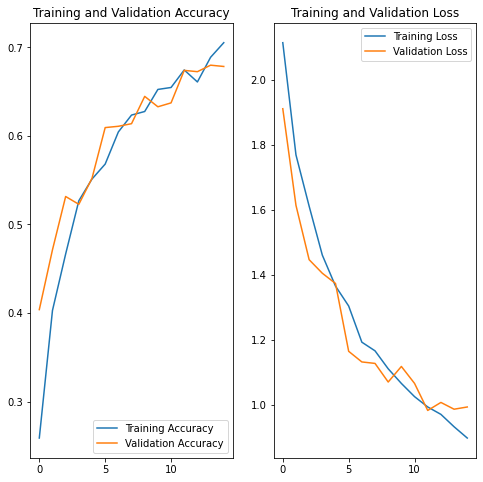

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## predicting for an image 

In [44]:
img = tf.keras.utils.load_img(
    '/content/drive/MyDrive/clothing-dataset-small-master/test/dress/28b09463-6bbb-491d-9ffc-f36df5c6b211.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dress with a 76.60 percent confidence.


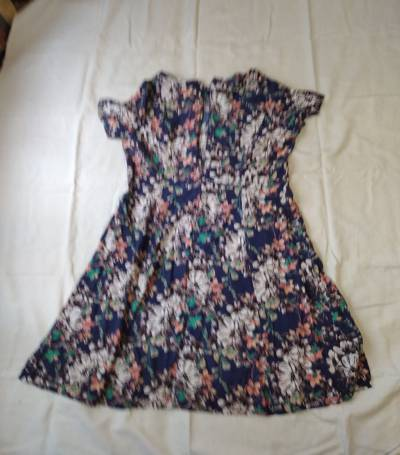

In [45]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/clothing-dataset-small-master/test/dress/28b09463-6bbb-491d-9ffc-f36df5c6b211.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)